# Preferential Bayesian Optimization: RANDOM
This notebook demonstrates the use of random querying on ordinal (preference) data.

Formulation by Nguyen Quoc Phong.

In [1]:
import numpy as np
import gpflow
import tensorflow as tf
import matplotlib.pyplot as plt
import sys
import os
import pickle

from gpflow.utilities import set_trainable, print_summary
gpflow.config.set_default_summary_fmt("notebook")

sys.path.append(os.path.split(os.path.split(os.path.split(os.getcwd())[0])[0])[0]) # Move 3 levels up directory to import PBO
import PBO

In [2]:
objective = PBO.objectives.forrester
objective_low = 0.
objective_high = 1.
objective_name = "Forrester"
acquisition_name = "RANDOM"
experiment_name = "PBO" + "_" + acquisition_name + "_" + objective_name

In [3]:
num_runs = 20
num_evals = 20
num_samples = 100
num_choices = 2
input_dims = 1
num_maximizers = 20
num_init_points = 3
num_inducing_init = 3
num_discrete_per_dim = 10000 # Discretization of continuous input space

In [4]:
results_dir = os.getcwd() + '/results/' + experiment_name + '/'

try:
    # Create target Directory
    os.makedirs(results_dir)
    print("Directory " , results_dir ,  " created ") 
except FileExistsError:
    print("Directory " , results_dir ,  " already exists")

Directory  /home/sebtsh/PBO/notebooks/RANDOM/results/PBO_RANDOM_Forrester/  already exists


Plot of the Forrester function (global min at ~0.757):

(-0.0, 1.0)

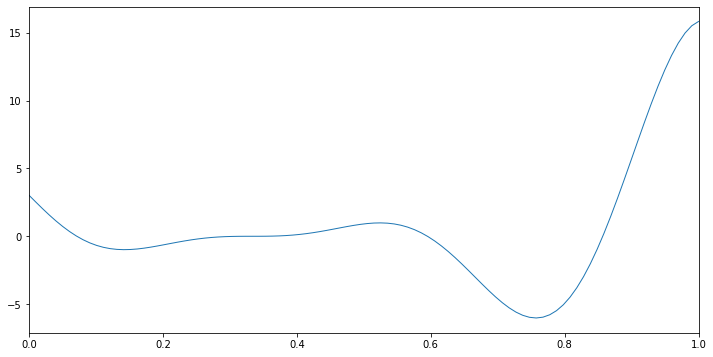

In [5]:
xx = np.linspace(0.0, 1.0, 100).reshape(100, 1)
plt.figure(figsize=(12, 6))
plt.plot(xx, objective(xx), 'C0', linewidth=1)
plt.xlim(-0.0, 1.0)

In [6]:
def plot_gp(model, X, y, title, cmap="Spectral"):
    #Plotting code from GPflow authors

    ## generate test points for prediction
    xx = np.linspace(-0.1, 1.1, 100).reshape(100, 1)  # test points must be of shape (N, D)

    ## predict mean and variance of latent GP at test points
    mean, var = model.predict_f(xx)

    ## generate 10 samples from posterior
    samples = model.predict_f_samples(xx, 10)  # shape (10, 100, 1)

    ## plot 
    plt.figure(figsize=(12, 6))
    plt.plot(X, y, 'kx', mew=2)
    plt.plot(xx, mean, 'C0', lw=2)
    plt.fill_between(xx[:,0],
                     mean[:,0] - 1.96 * np.sqrt(var[:,0]),
                     mean[:,0] + 1.96 * np.sqrt(var[:,0]),
                     color='C0', alpha=0.2)

    plt.plot(xx, samples[:, :, 0].numpy().T, 'C0', linewidth=.5)
    plt.xlim(-0.1, 1.1)
    plt.title(title)

    plt.savefig(fname=results_dir + title + ".png")

In [7]:
def get_noisy_observation(X, objective):
    f = PBO.objectives.objective_get_f_neg(X, objective)
    return PBO.observation_model.gen_observation_from_f(X, f, 1)

In [8]:
def train_and_visualize(X, y, num_inducing, title):
    
    # Train model with data
    q_mu, q_sqrt, u, inputs, k, indifference_threshold = PBO.models.learning_stochastic.train_model_fullcov(X, y, 
                                                                         num_inducing=num_inducing,
                                                                         obj_low=objective_low,
                                                                         obj_high=objective_high,
                                                                         lengthscale=0.05,
                                                                         num_steps=3000)
    likelihood = gpflow.likelihoods.Gaussian()
    model = PBO.models.learning.init_SVGP_fullcov(q_mu, q_sqrt, u, k, likelihood)
    u_mean = q_mu.numpy()
    inducing_vars = u.numpy()
    
    # Visualize model
    plot_gp(model, inducing_vars, u_mean, title)
    
    return model, inputs, u_mean, inducing_vars

In [9]:
def uniform_grid(input_dims, num_discrete_per_dim, low=0., high=1.):
    """
    Returns an array with all possible permutations of discrete values in input_dims number of dimensions.
    :param input_dims: int
    :param num_discrete_per_dim: int
    :param low: int
    :param high: int
    :return: tensor of shape (num_discrete_per_dim ** input_dims, input_dims)
    """
    num_points = num_discrete_per_dim ** input_dims
    out = np.zeros([num_points, input_dims])
    discrete_points = np.linspace(low, high, num_discrete_per_dim)
    for i in range(num_points):
        for dim in range(input_dims):
            val = num_discrete_per_dim ** (dim)
            out[i, dim] = discrete_points[int((i // val) % num_discrete_per_dim)]
    return out

This function is our main metric for the performance of the acquisition function: The closer the model's best guess to the target (in this case, the global minimum of the Forrester function), the better.

In [10]:
def best_guess(model):
    """
    :return: tensor of shape (input_dims) a GP model's best guess of the global maximum of f.
    """
    xx = uniform_grid(input_dims, num_discrete_per_dim, low=objective_low, high=objective_high)
    res = model.predict_f(xx)[0].numpy()
    return xx[np.argmax(res)]

Store the results in these arrays:

In [11]:
num_data_at_end = int((num_init_points-1) * num_init_points / 2 + num_evals)
X_results = np.zeros([num_runs, num_data_at_end, num_choices, input_dims])
y_results = np.zeros([num_runs, num_data_at_end, 1, input_dims])
best_guess_results = np.zeros([num_runs, num_evals, input_dims])

Create the initial values for each run:

In [12]:
np.random.seed(0)
init_points = np.random.uniform(low=objective_low, high=objective_high, size=[num_runs, num_init_points, input_dims])
num_combs = int((num_init_points-1) * num_init_points / 2)
init_vals = np.zeros([num_runs, num_combs, num_choices, input_dims])
for run in range(num_runs):
    cur_idx = 0
    for init_point in range(num_init_points-1):
        for next_point in range(init_point+1, num_init_points):
            init_vals[run, cur_idx, 0] = init_points[run, init_point]
            init_vals[run, cur_idx, 1] = init_points[run, next_point]
            cur_idx += 1

The following loops carry out the Bayesian optimization algorithm over a number of runs, with a fixed number of evaluations per run.

Beginning run 0
Indifference_threshold is trainable.
Instructions for updating:
Use tf.identity instead.
Negative ELBO at step 0: 2.870429495968072 in 0.2721s
Negative ELBO at step 500: 2.5510363776260103 in 53.8057s
Negative ELBO at step 1000: 2.217430515240331 in 51.5972s
Negative ELBO at step 1500: 2.1592185245502487 in 51.8155s
Negative ELBO at step 2000: 2.1318885983627855 in 64.2363s
Negative ELBO at step 2500: 2.20281174077455 in 57.7538s
Beginning evaluation 0
Evaluation 0: Next query is [[0.5488135 ]
 [0.01357164]]
Evaluation 0: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 3.802509443507685 in 0.2088s
Negative ELBO at step 500: 2.8600200863012066 in 76.0246s
Negative ELBO at step 1000: 2.914531012482199 in 77.9647s
Negative ELBO at step 1500: 2.8363987232963215 in 76.7575s
Negative ELBO at step 2000: 2.7709649381972583 in 73.3374s
Negative ELBO at step 2500: 2.905159809875101 in 77.9484s
Beginning evaluation 1
Evaluation 1: Next query is [[0.602

Negative ELBO at step 0: 961.4555895055049 in 1.9586s
Negative ELBO at step 500: 18.943672034414796 in 277.4577s
Negative ELBO at step 1000: 13.736050664140603 in 274.8003s
Negative ELBO at step 1500: 12.49205674535804 in 278.6173s
Negative ELBO at step 2000: 11.471353836183482 in 275.7961s
Negative ELBO at step 2500: 11.466778711975993 in 278.3414s
Beginning evaluation 16
Evaluation 16: Next query is [[0.05058812]
 [0.98069967]]
Evaluation 16: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 904222.9017912456 in 1.9912s
Negative ELBO at step 500: 2414.202668471555 in 291.6362s
Negative ELBO at step 1000: 946.6324987942698 in 294.6768s
Negative ELBO at step 1500: 536.8603598621529 in 285.1475s
Negative ELBO at step 2000: 321.3691294963509 in 304.5877s
Negative ELBO at step 2500: 295.07016516073855 in 287.3842s
Beginning evaluation 17
Evaluation 17: Next query is [[0.60484552]
 [0.86055117]]
Evaluation 17: Training model
Indifference_threshold is trainable.
N

name,class,transform,prior,trainable,shape,dtype,value
SquaredExponential.variance,Parameter,Softplus,,True,(),float64,1.0
SquaredExponential.lengthscale,Parameter,Softplus + Shift,,True,"(1,)",float64,[0.05]


ValueError: 

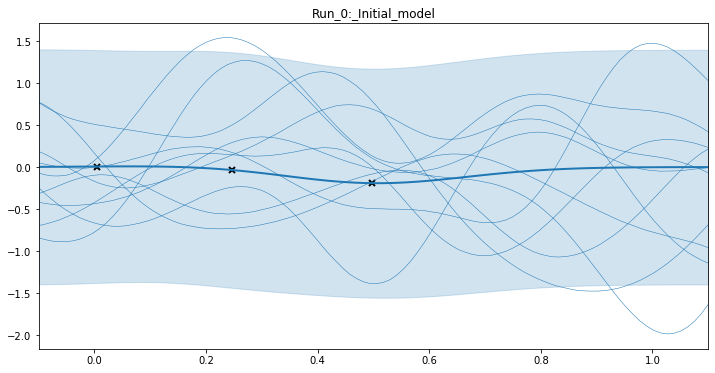

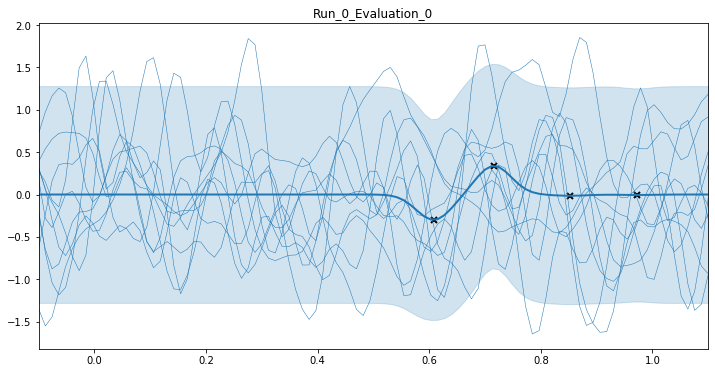

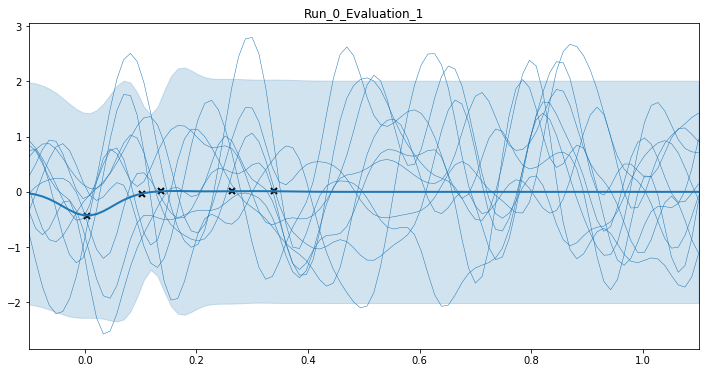

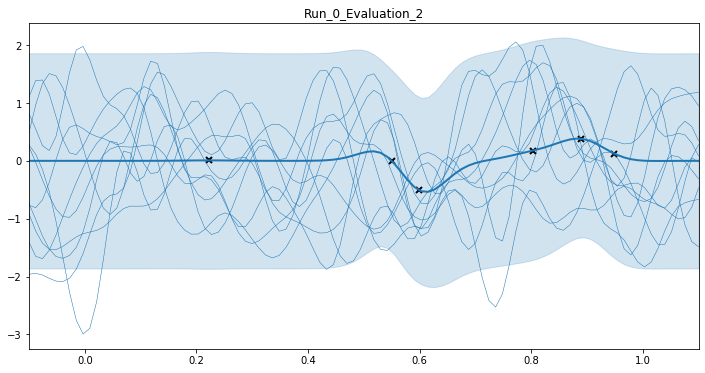

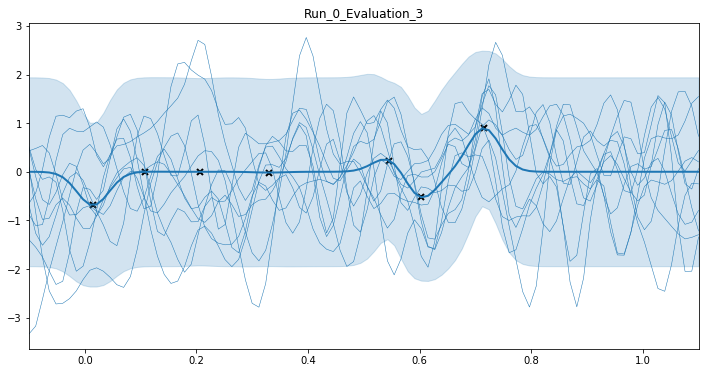

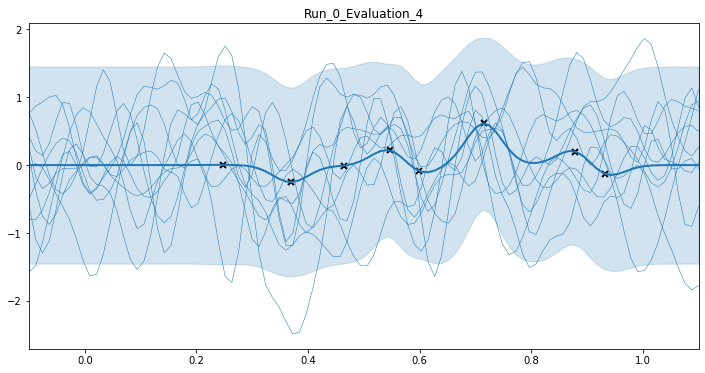

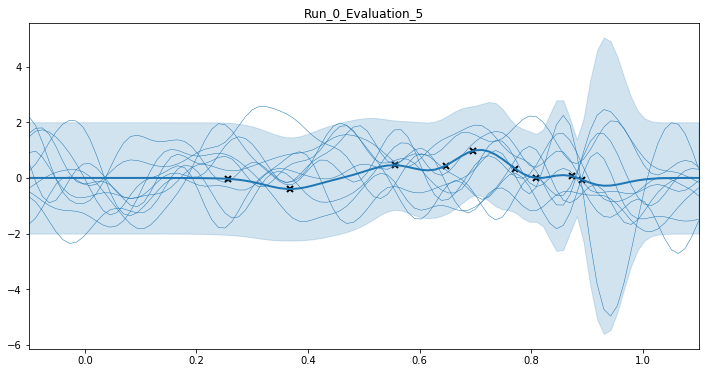

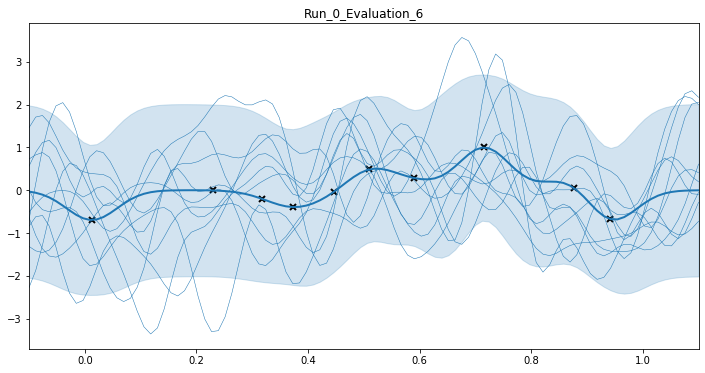

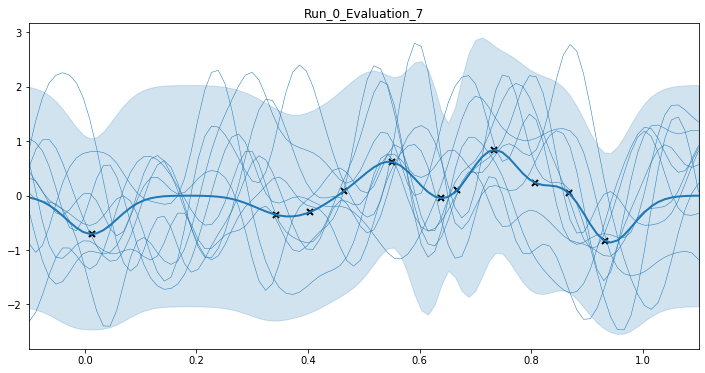

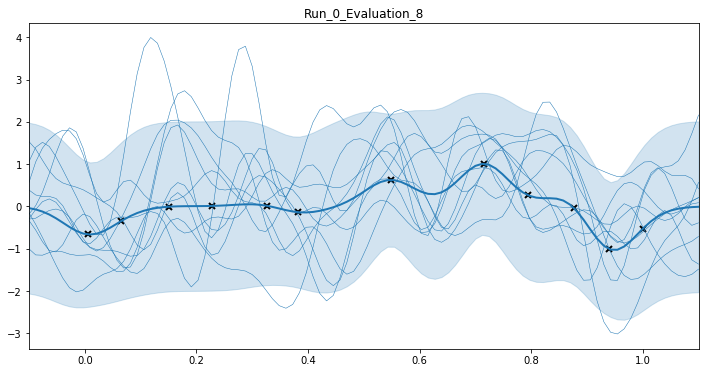

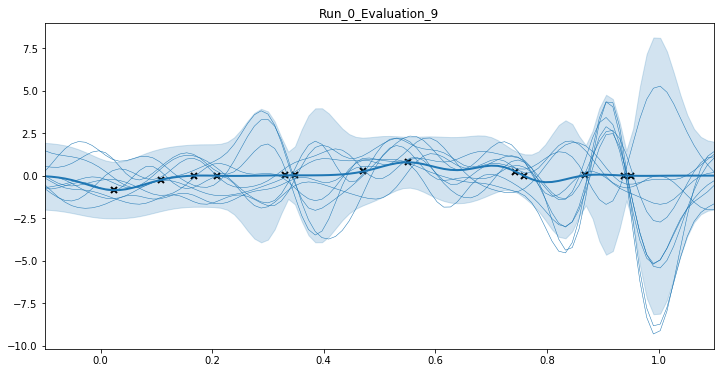

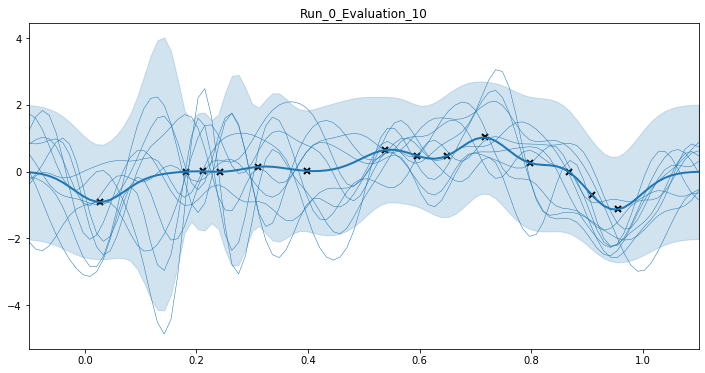

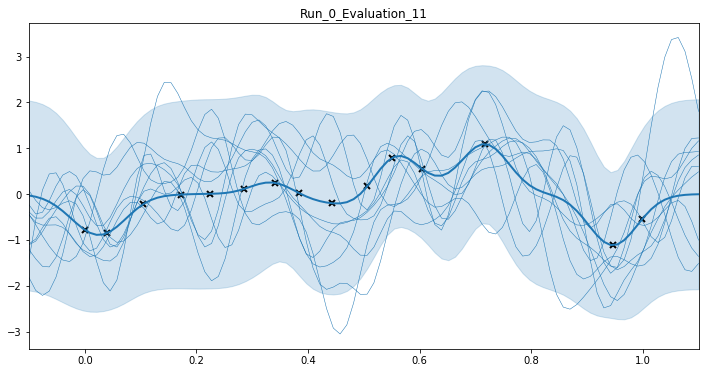

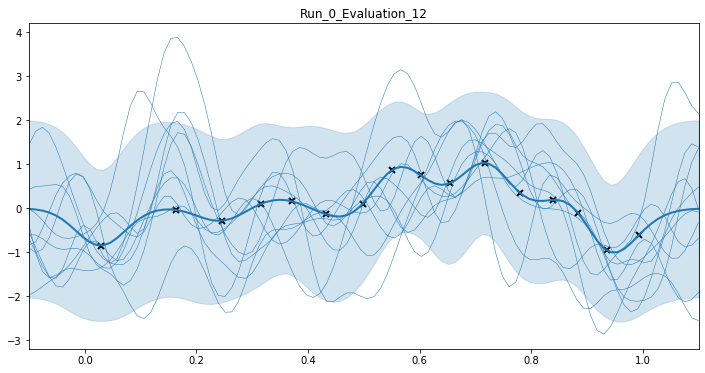

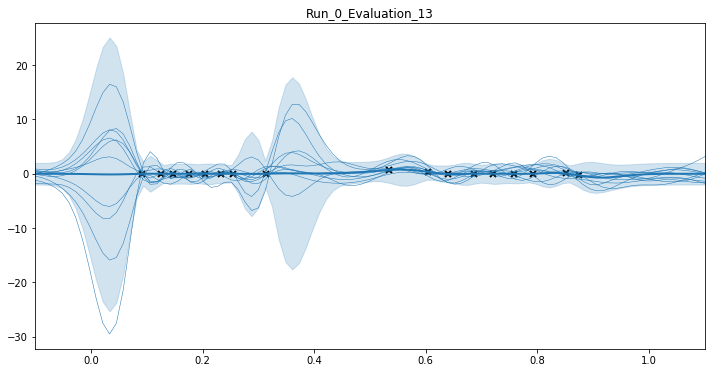

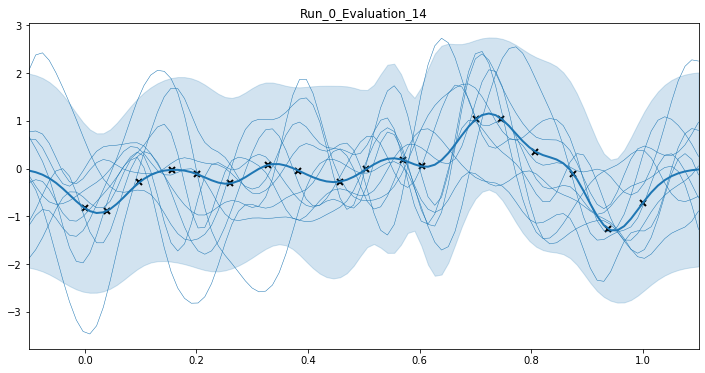

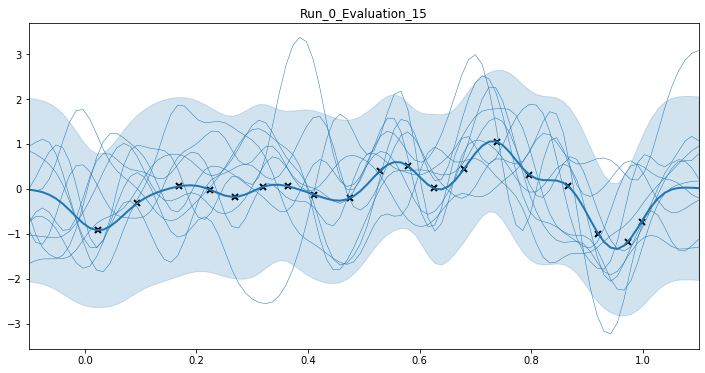

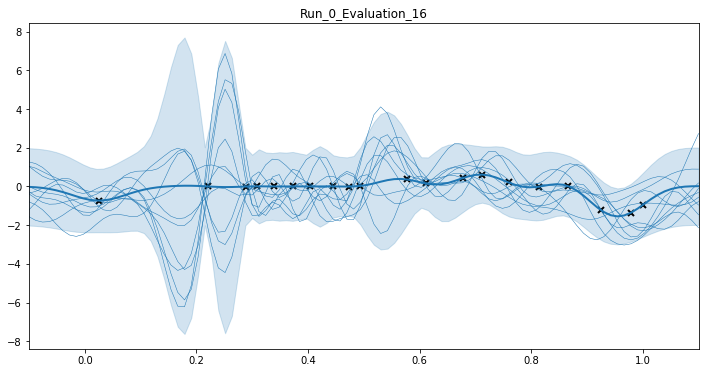

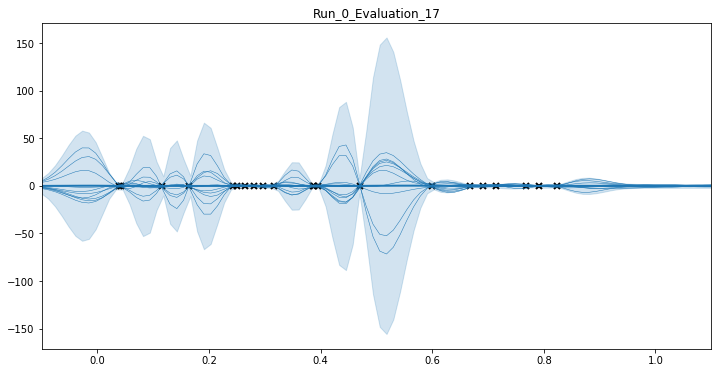

In [13]:
for run in range(num_runs):
    print("Beginning run %s" % (run))
    
    X = init_vals[run]
    y = get_noisy_observation(X, objective)
    
    model, inputs, u_mean, inducing_vars = train_and_visualize(X, y, num_inducing_init, "Run_{}:_Initial_model".format(run))

    for evaluation in range(num_evals):
        print("Beginning evaluation %s" % (evaluation)) 
        
        existing_idx = np.random.randint(0, inputs.shape[0])
        existing_input = inputs[existing_idx]
        random_input = np.random.uniform(low=objective_low, 
                                         high=objective_high, 
                                         size=(1, input_dims))
        
        next_query = np.zeros((num_choices, input_dims))
        next_query[0, :] = existing_input
        next_query[1, :] = random_input
        print("Evaluation %s: Next query is %s" % (evaluation, next_query))

        X = np.concatenate([X, [next_query]])
        # Evaluate objective function
        y = np.concatenate([y, get_noisy_observation(np.expand_dims(next_query, axis=0), objective)], axis=0)
        
        print("Evaluation %s: Training model" % (evaluation))
        model, inputs, u_mean, inducing_vars = train_and_visualize(X, y, 
                                                                   num_inducing_init + evaluation + 1, 
                                                                   "Run_{}_Evaluation_{}".format(run, evaluation))

        best_guess_results[run, evaluation, :] = best_guess(model)

    X_results[run] = X
    y_results[run] = y

In [ ]:
# u = np.array([[0.71517875],
#        [0.49081861],
#        [0.4694983 ],
#        [0.88270929],
#        [0.48841006],
#        [0.41456749],
#        [0.17411195],
#        [0.47528944],
#        [0.78364797],
#        [0.55642943],
#        [0.15986708],
#        [0.14382937],
#        [0.64946303],
#        [0.5392236 ],
#        [0.32568477],
#        [0.14701389],
#        [0.15987007],
#        [0.12941234],
#        [0.57892239],
#        [0.09226017],
#        [0.91054472],
#        [0.08297175]])

In [78]:
u = np.array([[0.71517875],
       [0.49081861],
       [0.1 ],
       [0.88270929],
       [0.2],
       [0.41456749],
       [0.17411195],
       [0.3],
       [0.78364797],
       [0.4],
       [0.15986708],
       [0.14382937],
       [0.64946303],
       [0.5392236 ],
       [0.32568477],
       [0.14701389],
       [0.15987007],
       [0.12941234],
       [0.57892239],
       [0.09226017],
       [0.91054472],
       [0.08297175]])

In [93]:
u = np.expand_dims(np.linspace(0, 1, 22), axis=1)

In [108]:
import tensorflow_probability as tfp

tensorflow_probability.python.distributions.gamma.Gamma

In [114]:
kernel.lengthscale.prior = tfp.distributions.Gamma(1, 1)

In [115]:
print_summary(kernel)

name,class,transform,prior,trainable,shape,dtype,value
SquaredExponential.variance,Parameter,Softplus,,True,(),float64,1.0
SquaredExponential.lengthscale,Parameter,Softplus + Shift,Gamma,True,"(1,)",float64,[1.]


In [102]:
lengthscale = 1
kernel = gpflow.kernels.RBF(lengthscale=[lengthscale for i in range(input_dims)])
kernel.lengthscale.transform = gpflow.utilities.bijectors.positive(lower=gpflow.default_jitter())

In [116]:
Kmm = kernel.K(u)

In [117]:
Kmm

<tf.Tensor: shape=(22, 22), dtype=float64, numpy=
array([[1.        , 0.99886686, 0.99547512, 0.9898478 , 0.98202296,
        0.97205327, 0.96000544, 0.94595947, 0.93000775, 0.91225408,
        0.8928125 , 0.87180613, 0.84936582, 0.82562882, 0.8007374 ,
        0.77483743, 0.74807695, 0.72060481, 0.69256932, 0.66411693,
        0.63539099, 0.60653066],
       [0.99886686, 1.        , 0.99886686, 0.99547512, 0.9898478 ,
        0.98202296, 0.97205327, 0.96000544, 0.94595947, 0.93000775,
        0.91225408, 0.8928125 , 0.87180613, 0.84936582, 0.82562882,
        0.8007374 , 0.77483743, 0.74807695, 0.72060481, 0.69256932,
        0.66411693, 0.63539099],
       [0.99547512, 0.99886686, 1.        , 0.99886686, 0.99547512,
        0.9898478 , 0.98202296, 0.97205327, 0.96000544, 0.94595947,
        0.93000775, 0.91225408, 0.8928125 , 0.87180613, 0.84936582,
        0.82562882, 0.8007374 , 0.77483743, 0.74807695, 0.72060481,
        0.69256932, 0.66411693],
       [0.9898478 , 0.99547512, 0.9

In [104]:
tf.linalg.logdet(kernel.K(u))

InvalidArgumentError: Cholesky decomposition was not successful. The input might not be valid. [Op:Cholesky]

In [105]:
Kmm

<tf.Tensor: shape=(22, 22), dtype=float64, numpy=
array([[1.        , 0.99886686, 0.99547512, 0.9898478 , 0.98202296,
        0.97205327, 0.96000544, 0.94595947, 0.93000775, 0.91225408,
        0.8928125 , 0.87180613, 0.84936582, 0.82562882, 0.8007374 ,
        0.77483743, 0.74807695, 0.72060481, 0.69256932, 0.66411693,
        0.63539099, 0.60653066],
       [0.99886686, 1.        , 0.99886686, 0.99547512, 0.9898478 ,
        0.98202296, 0.97205327, 0.96000544, 0.94595947, 0.93000775,
        0.91225408, 0.8928125 , 0.87180613, 0.84936582, 0.82562882,
        0.8007374 , 0.77483743, 0.74807695, 0.72060481, 0.69256932,
        0.66411693, 0.63539099],
       [0.99547512, 0.99886686, 1.        , 0.99886686, 0.99547512,
        0.9898478 , 0.98202296, 0.97205327, 0.96000544, 0.94595947,
        0.93000775, 0.91225408, 0.8928125 , 0.87180613, 0.84936582,
        0.82562882, 0.8007374 , 0.77483743, 0.74807695, 0.72060481,
        0.69256932, 0.66411693],
       [0.9898478 , 0.99547512, 0.9

In [98]:
tf.linalg.cholesky(Kmm)

<tf.Tensor: shape=(22, 22), dtype=float64, numpy=
array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [8.92812502e-01, 4.50428504e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [6.35390989e-01, 7.22706225e-01, 2.71981625e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
    

In [100]:
tf.linalg.inv(Kmm) @ Kmm

<tf.Tensor: shape=(22, 22), dtype=float64, numpy=
array([[ 9.99999996e-01, -7.58687243e-09, -1.58222546e-08,
        -3.08774582e-08, -5.21156269e-08, -7.09974288e-08,
        -7.24210050e-08, -4.57133285e-08,  2.43282745e-09,
         4.71926352e-08,  6.03901522e-08,  2.98141955e-08,
        -3.13803746e-08, -9.14805538e-08, -1.19456977e-07,
        -1.04187054e-07, -6.00003363e-08, -1.45404453e-08,
         1.12596563e-08,  1.47665400e-08,  6.90891255e-09,
        -7.26245730e-10],
       [ 1.20639454e-08,  1.00000003e+00,  5.83652327e-08,
         1.16963288e-07,  1.99821246e-07,  2.72805629e-07,
         2.76690288e-07,  1.70459492e-07, -1.84958590e-08,
        -1.91897396e-07, -2.37222014e-07, -1.02586199e-07,
         1.62686562e-07,  4.28413906e-07,  5.58707870e-07,
         4.97132952e-07,  2.99886457e-07,  8.92128433e-08,
        -3.63716808e-08, -5.98089400e-08, -2.84678094e-08,
         4.38402026e-09],
       [-1.80196561e-08, -4.32602658e-08,  9.99999899e-01,
        -2.11

In [101]:
PBO.models.learning_stochastic.cholesky_matrix_inverse(Kmm) @ Kmm

<tf.Tensor: shape=(22, 22), dtype=float64, numpy=
array([[ 1.00000000e+00,  1.62636698e-12, -2.99856418e-11,
        -9.27059256e-11, -1.85011460e-10, -2.74315775e-10,
        -3.25784552e-10, -3.05057513e-10, -2.22381381e-10,
        -1.10316209e-10, -3.37672783e-11, -4.42463964e-12,
        -1.33623698e-11, -2.77948220e-11, -3.05163395e-11,
        -2.20062857e-11, -1.03184128e-11, -4.31477076e-12,
        -1.36068934e-12, -4.61852778e-14, -2.48689958e-13,
        -4.61852778e-14],
       [-6.80102500e-11,  1.00000000e+00,  1.62366032e-10,
         5.08106566e-10,  1.00730762e-09,  1.49963528e-09,
         1.78932784e-09,  1.68395625e-09,  1.22943550e-09,
         6.19361802e-10,  1.94830942e-10,  2.41144366e-11,
         7.51342061e-11,  1.54104091e-10,  1.71841763e-10,
         1.24171340e-10,  5.81383830e-11,  2.67057487e-11,
         9.47864010e-12,  7.81597009e-13,  1.33582034e-12,
         7.38964445e-13],
       [ 1.88535877e-10,  2.18550374e-11,  1.00000000e+00,
        -1.52

In [120]:
np.linspace(0., 1., 5)[1:4]

array([0.25, 0.5 , 0.75])

In [ ]:
pickle.dump((X_results, y_results, best_guess_results), open(results_dir + "Xybestguess.p", "wb"))

In [ ]:
def dist(x, y):
    """
    x and y have shape (..., input_dims)
    """
    return np.sqrt(np.sum((x - y) * (x - y), axis=-1))

In [ ]:
xx = uniform_grid(input_dims, num_discrete_per_dim, low=objective_low, high=objective_high)
global_min = xx[np.argmin(objective(xx))][0]

for i in range(best_guess_results.shape[0]):
    diff_from_min = dist(best_guess_results[i], global_min)
    
    x_axis = list(range(num_combs+1, num_combs+1+num_evals))
    plt.figure(figsize=(12, 6))
    plt.plot(x_axis, diff_from_min, 'kx', mew=2)
    plt.xticks(x_axis)
    plt.xlabel('Evaluations', fontsize=18)
    plt.ylabel('Best guess distance', fontsize=16)
    plt.title("Run %s" % i)
    plt.show()